In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Step 1: Load the Data
df = pd.read_csv('NFLX.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
# Summary of the variables
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
              Open         High          Low        Close    Adj Close  \
count  1009.000000  1009.000000  1009.000000  1009.000000  1009.000000   
mean    419.059673   425.320703   412.374044   419.000733   419.000733   
std     108.537532   109.262960   107.555867   108.289999   108.289999   
min     233.919998   250.649994   231.229996   233.880005   233.880005   
25%     331.489990   336.299988   326.000000   331.619995   331.619995   
50%     377.769989   383.010010   370.880005   378.670013   378.670013   
75%     509.130005   515.630005   502.529999   509.079987   509.079987   
max     692.349976   700.989990   686.090027   691.690002   691.690002   

             Volume  
count  1.009000e+03  
mean   7.570685e+06  
std    5.465535e+06  
min    1.144000e+06  
25%    4.091900e+06  
50%    5.934500e+06  
75%    9.322400e+06  
max    5.890430e+07  


In [5]:
#Check if there are missing values. We can see all the values are zero. This indicates that no variables has missing value

print("\nCheck for missing values:")
print(df.isnull().sum())


Check for missing values:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


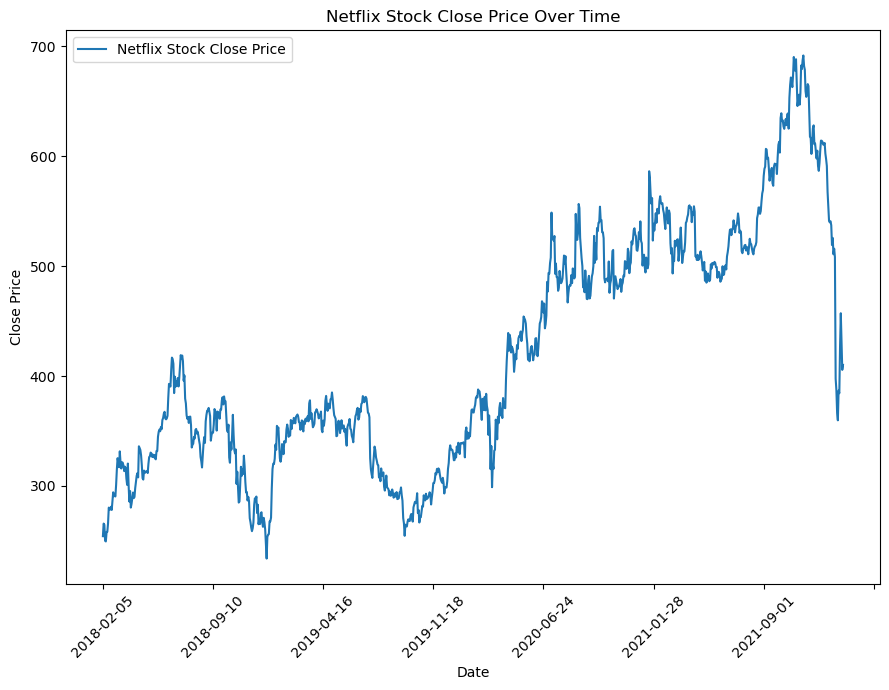

In [7]:
plt.figure(figsize=(9, 7))
plt.plot(df['Date'], df['Close'], label='Netflix Stock Close Price')
plt.title('Netflix Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set a tick interval, e.g., every 6 months
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.legend()
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

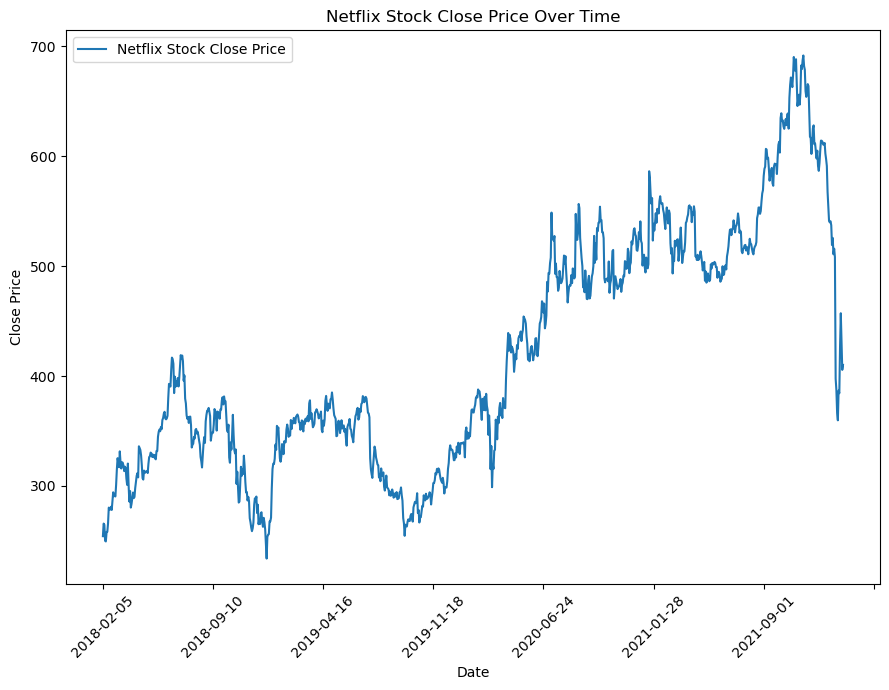

In [8]:
plt.figure(figsize=(9, 7))
plt.plot(df['Date'], df['Adj Close'], label='Netflix Stock Close Price')
plt.title('Netflix Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set a tick interval, e.g., every 6 months
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

plt.legend()
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

In [9]:
# Step 2: Prepare the Data
# Ensure that the 'Date' column is properly handled and converted to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date (just in case)
df = df.sort_values('Date')

# Drop other columns if we're only focusing on closing prices for simplicity
data = df[['Close']]


In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [11]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Close'])


In [ ]:
#scaled_df.head()

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)  # Use .iloc to access the rows by index
        y.append(data.iloc[i + seq_length].values)  # Predict the next value after the sequence
    return np.array(X), np.array(y)


In [13]:
# Define sequence length and create sequences
sequence_length = 90  # Using the last 90 days to predict the next day
X, y = create_sequences(scaled_df, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [14]:
# Reshape the data to match LSTM input requirements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
# Step 3: Build the LSTM Model with Tuning Improvements
models = Sequential()
models.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Increased units
models.add(Dropout(0.4))  
models.add(LSTM(units=64, return_sequences=False))  # Increased units
models.add(Dropout(0.4))  # Increased dropout rate to prevent overfitting
models.add(Dense(units=32, activation='relu'))  # Added activation function to the dense layer
models.add(Dense(units=1))


In [16]:
# Compile the model
models.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Step 4: Train the Model
history = models.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)  # Increased epochs

Epoch 1/50
23/23 [==============================] - 62s 631ms/step - loss: 0.0536 - val_loss: 0.0573
Epoch 2/50
23/23 [==============================] - 6s 264ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch 3/50
23/23 [==============================] - 7s 314ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 4/50
23/23 [==============================] - 8s 331ms/step - loss: 0.0052 - val_loss: 0.0080
Epoch 5/50
23/23 [==============================] - 7s 291ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 6/50
23/23 [==============================] - 6s 253ms/step - loss: 0.0042 - val_loss: 0.0097
Epoch 7/50
23/23 [==============================] - 4s 196ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 8/50
23/23 [==============================] - 6s 276ms/step - loss: 0.0043 - val_loss: 0.0107
Epoch 9/50
23/23 [==============================] - 7s 327ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 10/50
23/23 [==============================] - 8s 329ms/step - loss: 0.0039 - val_loss: 0.005

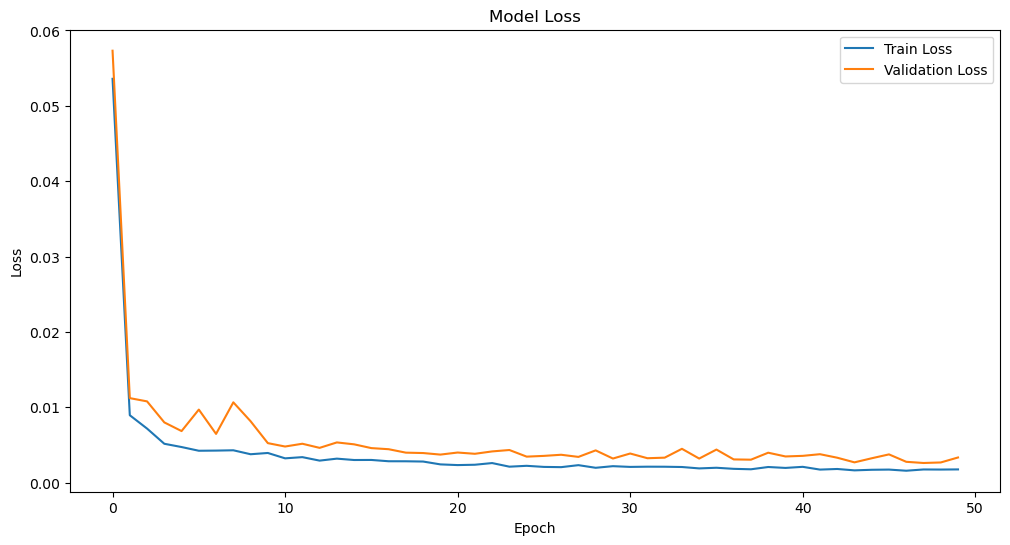

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 10s 57ms/step


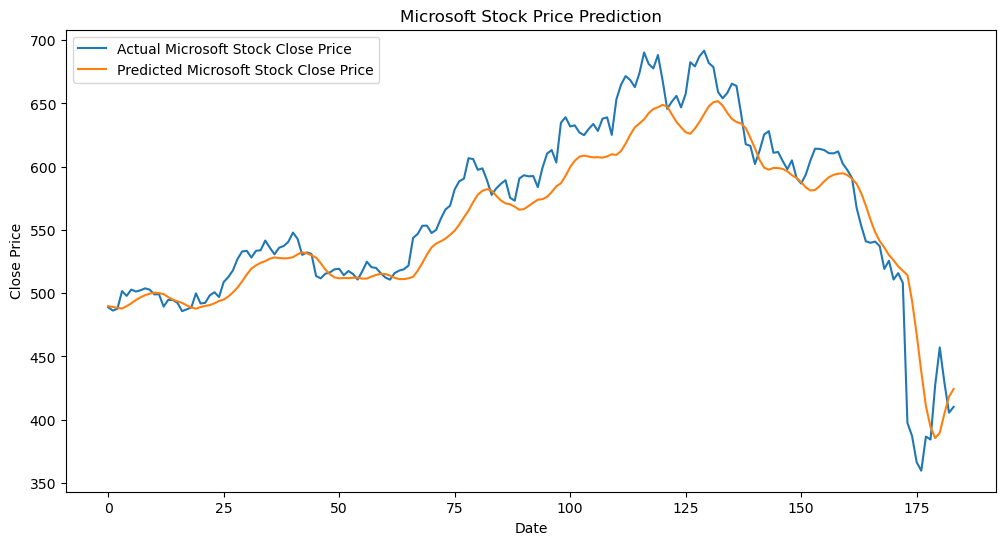

In [19]:

# Step 5: Evaluate and Make Predictions
predictions = models.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Microsoft Stock Close Price')
plt.plot(predictions, label='Predicted Microsoft Stock Close Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 415ms/step


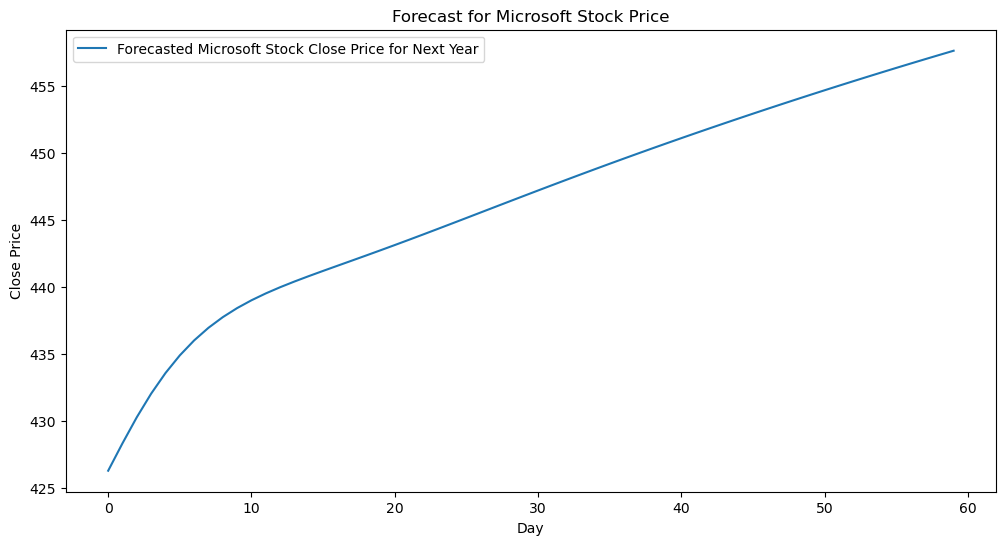

In [20]:
# Step 6: Forecasting the Next Year
# Use the last `sequence_length` days of data to start the prediction
last_sequence = scaled_data[-sequence_length:]
predictions_for_year = []

for _ in range(60):
    # Predict the next value
    pred = models.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions_for_year.append(pred[0, 0])
    
    # Update the sequence with the new prediction
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the predictions to the original scale
predictions_for_year = scaler.inverse_transform(np.array(predictions_for_year).reshape(-1, 1))

# Plot the forecast for the next year
plt.figure(figsize=(12, 6))
plt.plot(predictions_for_year, label='Forecasted Microsoft Stock Close Price for Next Year')
plt.title('Forecast for Microsoft Stock Price')
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.legend()
plt.show()



6/6 [==============================] - 1s 86ms/step


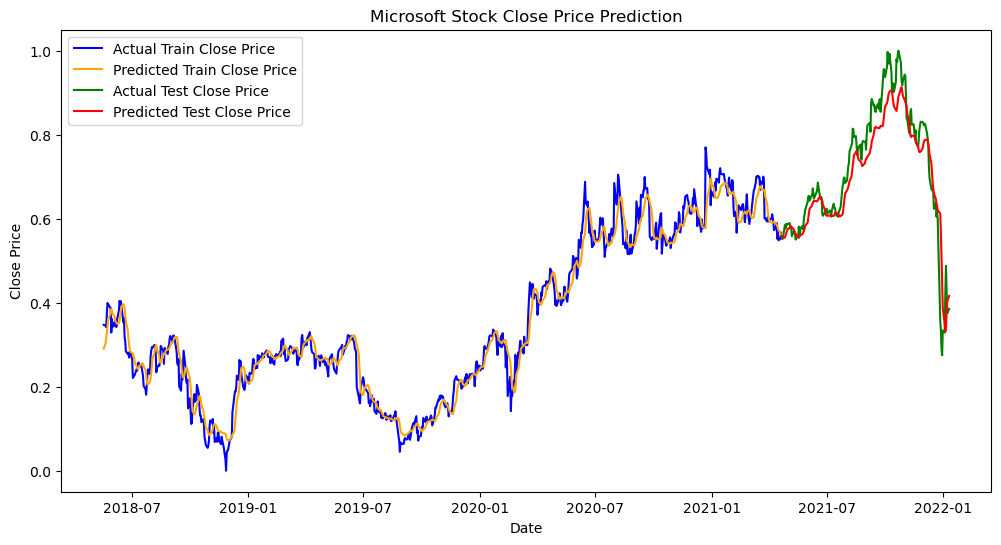

In [21]:
# Predict the values
y_pred_trains = models.predict(X_train).flatten()
y_pred_tests = models.predict(X_test).flatten()

# Split dates into train and test based on the original data
datetrain_sizes = int(len(df['Date']) * 0.8)
Xdate_trains = df['Date'][:datetrain_sizes][-len(y_pred_trains):]  # Use only the last len(y_pred_train) dates
Xdate_tests = df['Date'][datetrain_sizes:datetrain_sizes + len(y_pred_tests)]  # Use only the first len(y_pred_test) dates

# Plotting the data
plt.figure(figsize=(12, 6))

# Training data plot
plt.plot(Xdate_trains, y_train.flatten()[-len(y_pred_trains):], label='Actual Train Close Price', color='blue')
plt.plot(Xdate_trains, y_pred_trains, label='Predicted Train Close Price', color='orange')

# Testing data plot
plt.plot(Xdate_tests, y_test.flatten(), label='Actual Test Close Price', color='green')
plt.plot(Xdate_tests, y_pred_tests, label='Predicted Test Close Price', color='red')

plt.title('Microsoft Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## COMBINE TWO MODELS TOGETHER

###  Bidirectional LSTM and GRU

#### USE BAYESIAN OPTIMIZATION TO OPTIMIZE 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [23]:
# Step 1: Load the Data
df = pd.read_csv('NFLX.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data = df[['Close']]

In [24]:
# Step 2: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=['Close'])

In [25]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length].values)
    return np.array(X), np.array(y)

In [26]:
# Define sequence length and create sequences
sequence_length = 90
X, y = create_sequences(scaled_df, sequence_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the data to match LSTM input requirements
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [27]:
# Define the hyperparameter space
space = [
    Integer(32, 128, name='units'),  # Number of LSTM units
    Real(0.1, 0.5, name='dropout_rate'),  # Dropout rate
    Integer(32, 128, name='dense_units'),  # Number of dense units
    Real(0.0001, 0.01, name='learning_rate')  # Learning rate
]

# Define the model-building function
@use_named_args(space)
def build_and_evaluate_model(units, dropout_rate, dense_units, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])
    
    val_loss = min(history.history['val_loss'])
    return val_loss


In [28]:
# Apply Bayesian Optimization
res_gp = gp_minimize(build_and_evaluate_model, space, n_calls=20, random_state=0, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 538.6863
Function value obtained: 0.0030
Current minimum: 0.0030
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 645.1513
Function value obtained: 0.0025
Current minimum: 0.0025
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 391.1472
Function value obtained: 0.0031
Current minimum: 0.0025
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 797.7627
Function value obtained: 0.0030
Current minimum: 0.0025
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 561.0622
Function value obtained: 0.0033
Current minimum: 0.0025
Iteration No: 6 started. 

In [29]:
# Print the best hyperparameters
print("Best hyperparameters found:")
print(f"Units: {res_gp.x[0]}")
print(f"Dropout Rate: {res_gp.x[1]}")
print(f"Dense Units: {res_gp.x[2]}")
print(f"Learning Rate: {res_gp.x[3]}")

Best hyperparameters found:
Units: 128
Dropout Rate: 0.1
Dense Units: 116
Learning Rate: 0.0001


In [30]:
# Step 4: Train the final model with the best hyperparameters
best_units = res_gp.x[0]
best_dropout_rate = res_gp.x[1]
best_dense_units = res_gp.x[2]
best_learning_rate = res_gp.x[3]

model = Sequential()
model.add(Bidirectional(LSTM(units=best_units, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model.add(Dropout(best_dropout_rate))
model.add(Bidirectional(LSTM(units=best_units)))
model.add(Dropout(best_dropout_rate))
model.add(Dense(best_dense_units, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/50
23/23 [==============================] - 67s 1s/step - loss: 0.0153 - val_loss: 0.0090
Epoch 2/50
23/23 [==============================] - 27s 1s/step - loss: 0.0022 - val_loss: 0.0045
Epoch 3/50
23/23 [==============================] - 28s 1s/step - loss: 0.0019 - val_loss: 0.0059
Epoch 4/50
23/23 [==============================] - 27s 1s/step - loss: 0.0019 - val_loss: 0.0039
Epoch 5/50
23/23 [==============================] - 26s 1s/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/50
23/23 [==============================] - 27s 1s/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/50
23/23 [==============================] - 27s 1s/step - loss: 0.0014 - val_loss: 0.0041
Epoch 8/50
23/23 [==============================] - 27s 1s/step - loss: 0.0016 - val_loss: 0.0042
Epoch 9/50
23/23 [==============================] - 27s 1s/step - loss: 0.0015 - val_loss: 0.0026
Epoch 10/50
23/23 [==============================] - 27s 1s/step - loss: 0.0014 - val_loss: 0.0041
Epoch 11/50
23/23 [

6/6 [==============================] - 9s 278ms/step


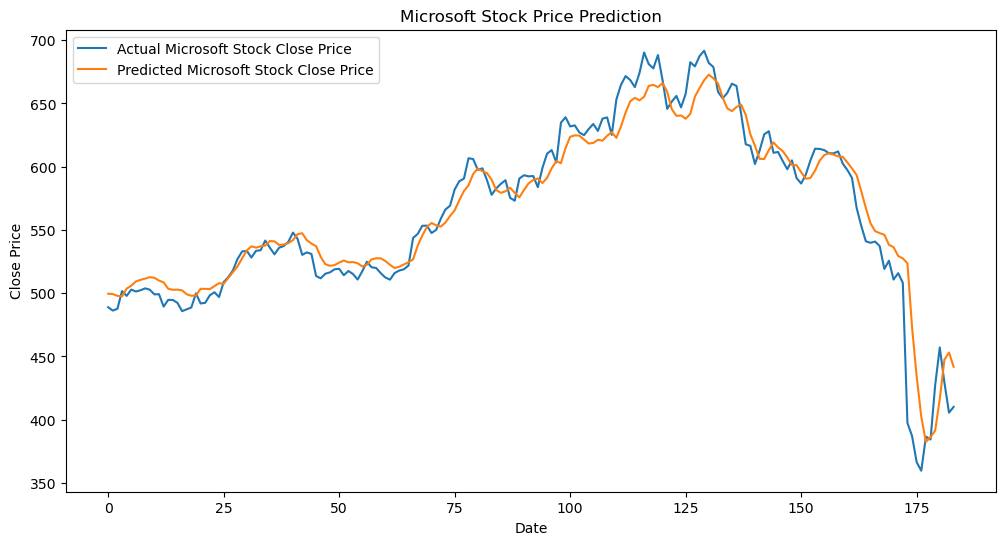

In [33]:
# Step 5: Evaluate and Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Microsoft Stock Close Price')
plt.plot(predictions, label='Predicted Microsoft Stock Close Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


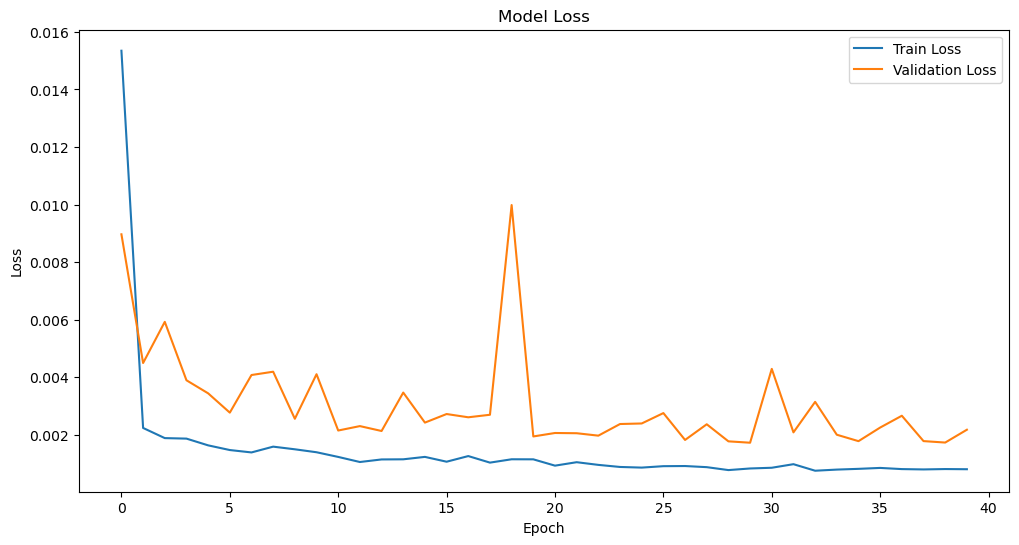

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 2s 323ms/step


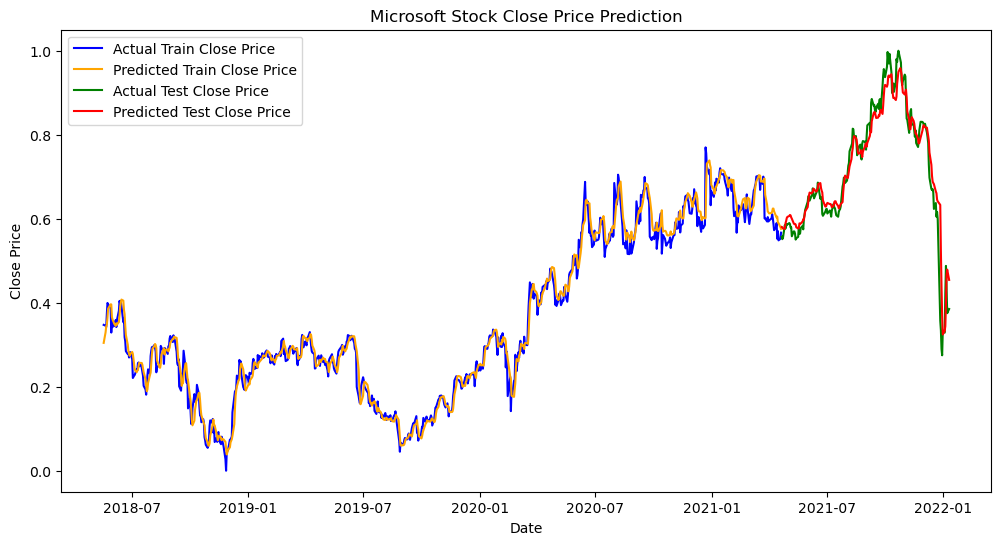

In [35]:
# Predict the values
y_pred_trains = model.predict(X_train).flatten()
y_pred_tests = model.predict(X_test).flatten()

# Split dates into train and test based on the original data
datetrain_sizes = int(len(df['Date']) * 0.8)
Xdate_trains = df['Date'][:datetrain_sizes][-len(y_pred_trains):]  # Use only the last len(y_pred_train) dates
Xdate_tests = df['Date'][datetrain_sizes:datetrain_sizes + len(y_pred_tests)]  # Use only the first len(y_pred_test) dates

# Plotting the data
plt.figure(figsize=(12, 6))

# Training data plot
plt.plot(Xdate_trains, y_train.flatten()[-len(y_pred_trains):], label='Actual Train Close Price', color='blue')
plt.plot(Xdate_trains, y_pred_trains, label='Predicted Train Close Price', color='orange')

# Testing data plot
plt.plot(Xdate_tests, y_test.flatten(), label='Actual Test Close Price', color='green')
plt.plot(Xdate_tests, y_pred_tests, label='Predicted Test Close Price', color='red')

plt.title('Microsoft Stock Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()